# 1. Load and parse the data
#### Code is primarily from Lydia's FICO-figures.ipynb 

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')
import fico
import distribution_to_loans_outcomes as dlo

# imports for my own code
import pandas as pd
from random import choices

DATA_DIR = '../data/'

In [3]:
# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

In [4]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);

In [5]:
cdfs = all_cdfs[["White","Black"]]

# B is White
# A is Black

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White']
repay_A = performance['Black']

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

In [6]:
# to populate group distributions
def get_pmf(cdf):
    pis = np.zeros(cdf.size)
    pis[0] = cdf[0]
    for score in range(cdf.size-1):
        pis[score+1] = cdf[score+1] - cdf[score]
    return pis

In [7]:
# basic parameters
N_scores = cdf_B.size
N_groups = 2

# get probability mass functions of each group
pi_A = get_pmf(cdf_A)
pi_B = get_pmf(cdf_B)
pis = np.vstack([pi_A, pi_B])

# demographic statistics 
group_ratio = np.array((totals["Black"], totals["White"]))
group_size_ratio = group_ratio/group_ratio.sum()
print(group_size_ratio)

[0.12066905 0.87933095]


In [8]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

# unpacking repay probability as a function of score
loan_repay_fns = [lambda x: loan_repaid_prob(x) for
                      loan_repaid_prob in loan_repaid_probs]

# 2. Simulate the data grabbed above

In [ ]:
# TODO: make the below a method in itself in a pyfile and input parameters into a main or function call to run it

In [9]:
# Round function described below used, round(float_num, num_of_decimals)
# Reference: https://www.guru99.com/round-function-python.html

def get_repay_probabilities(samples, repay_probs):
    sample_probs = []
    for index, score in enumerate(samples):
        prob_index = np.where(scores_arr == score)
        repay_prob = round(repay_probs[prob_index[0][0]], 2)
        sample_probs.insert(index, repay_prob)
        if index == 0 or index == 100:
            print(index)
            print(repay_prob)
    return sample_probs

def get_rounded_scores(scores):  # takes in a list and returns a list
    rounded_scores = []
    for index, score in enumerate(scores):
        rounded_score = round(score, 2) 
        rounded_scores.append(rounded_score)
        if index == 0 or index == 100:
            print(index)
            print(rounded_score)
    return rounded_scores
    

## 2.1 Convert the data in format needed

In [10]:
# Make repay probabilities into percentages from decimals
# NOTE: A is Black, B is White

scores_arr = np.asarray(get_rounded_scores(scores_list))
repay_A_arr = pd.Series.to_numpy(repay_A)*100
repay_B_arr = pd.Series.to_numpy(repay_B)*100

0
300.0
100
658.33


## 2.2 Sample from the data 

In [11]:
# Sample data according to the pmf
# Reference: https://www.w3schools.com/python/ref_random_choices.asp

num_A_samples = 120
num_B_samples = 880

samples_A = np.asarray(sorted(choices(scores_arr, pi_A, k=num_A_samples)))
samples_B = np.asarray(sorted(choices(scores_arr, pi_B, k=num_B_samples)))

## 2.3 Combine the scores and probabilities and convert data types

In [12]:
# Calculate samples groups' probabilities and make arrays for race
# A == Black == 0 (later defined as 0.0 when converting to pandas df)
# B == White == 1 (later defined as 1.0 when converting to pandas df)

samples_A_probs = np.asarray(get_repay_probabilities(samples=samples_A, repay_probs=repay_A_arr))
samples_A_race = np.asarray([0] * num_A_samples)

samples_B_probs = np.asarray(get_repay_probabilities(samples=samples_B, repay_probs=repay_B_arr))
samples_B_race = np.asarray([1] * num_B_samples)

data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs} #,'race': samples_A_race}
data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs} #,'race': samples_B_race}

# Convert from dict to df
data_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)
data_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)

# Combine all of the data together and shuffle
# NOTE: not currently being used but could be useful at a later time
data_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)
print(data_all_df)
data_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)
print(data_all_df_shuffled)

0
0.77
100
76.12
0
1.46
100
17.35
      score  repay_probability
0    311.90               0.77
1    311.90               0.77
2    311.90               0.77
3    311.90               0.77
4    323.81               1.20
..      ...                ...
995  836.84              99.02
996  841.23              99.05
997  841.23              99.05
998  841.23              99.05
999  845.61              99.07

[1000 rows x 2 columns]
      score  repay_probability
0    806.14              98.82
1    642.92              88.06
2    323.81               2.64
3    707.35              96.07
4    483.08              21.42
..      ...                ...
995  533.54              39.92
996  681.88              94.06
997  814.91              98.87
998  347.62               2.07
999  742.65              97.85

[1000 rows x 2 columns]


## 2.4 Save the pandas dataframes to CSVs

In [13]:
data_A_df.to_csv(index=False, path_or_buf='simData_2dec_groupA_black.csv')
data_B_df.to_csv(index=False, path_or_buf='simData_2dec_groupB_white.csv')

## 2.5 Inspect the min/max values of the data

In [14]:
## TODO: make a function for printing the min/max values of the respective groups for score and probability

In [15]:
max_val_A = np.max(samples_A_probs)
min_val_A = np.min(samples_A_probs)
print('the range of the Group A (Black) repay probabilities is: ', max_val_A-min_val_A)
print('the min value is: ', min_val_A)
print('the max value is: ', max_val_A)

the range of the Group A (Black) repay probabilities is:  96.56
the min value is:  0.77
the max value is:  97.33


In [16]:
max_val_B = np.max(samples_B_probs)
min_val_B = np.min(samples_B_probs)
print('the range of the Group B (White) repay probabilities is: ', max_val_B-min_val_B)
print('the min value is: ', min_val_B)
print('the max value is: ', max_val_B)

the range of the Group B (White) repay probabilities is:  97.61
the min value is:  1.46
the max value is:  99.07


## 2.6 Visualize the data

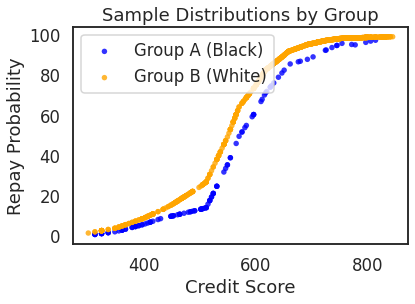

In [17]:
samples_all_A = (samples_A, samples_A_probs)
samples_all_B = (samples_B, samples_B_probs)
data = (samples_all_A, samples_all_B)
colors = ('blue', 'orange')
groups = ('Group A (Black)', 'Group B (White)')

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Sample Distributions by Group')
plt.legend(loc=2)
plt.xlabel('Credit Score')
plt.ylabel('Repay Probability')
plt.show()